# Binary Segmentation: PyTorch version
One wants to optimize the Jaccard index of the foreground class.
One can use either the Lovász Hinge or the Lovász-Sigmoid for binary problems.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division, print_function

In [3]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import Adam
from torch import nn

In [4]:
import lovasz_losses as L

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from tqdm import tqdm_notebook as tqdm

In [7]:
# add parent path to pythonpath to import demo_utils
import sys
sys.path.append('../demo_helpers')
from demo_utils import pil, pil_grid, dummy_triangles

In [8]:
CUDA = True

In [9]:
def cuda(x):
    if CUDA:
        return x.cuda()
    else:
        return x

## Batch of 10 random images with background (0), foreground (1), void (255) class

### Labels

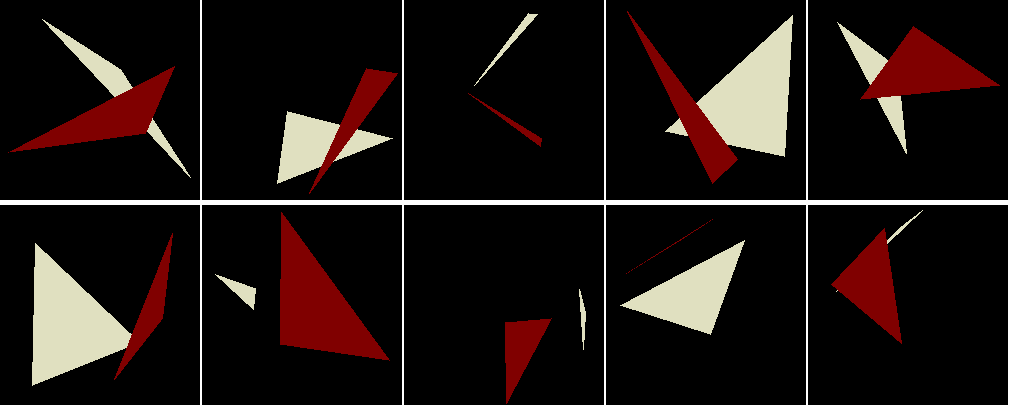

In [10]:
np.random.seed(18)
labels_ = [dummy_triangles(200, [0, 255, 1]) for b in range(10)]
labels = torch.stack([torch.from_numpy(a) for a in map(np.array, labels_)]).long()
pil_grid(labels_, 5, margin=1)

### Features

In [11]:
np.random.seed(57)
feats = labels.float()
feats[labels == 0] = feats[labels == 0].normal_(-1, 2.5)
feats[labels == 1] = feats[labels == 1].normal_(1, 2.5)
feats[labels == 255] = feats[labels == 255].normal_(0, 5)

In [12]:
feats = Variable(cuda(feats))
labels = cuda(labels)

## Model

In [13]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.bias = nn.Parameter(torch.Tensor([0]))
        
    def forward(self, x):
        return x + self.bias
    
m = Model()

In [14]:
m = cuda(m)

### Initial prediction

In [15]:
preds = (m(feats) > 0).long().data
print("Initial image-IoU:", L.iou_binary(preds, labels, ignore=255, per_image=False))

Initial image-IoU: 13.325895121209047


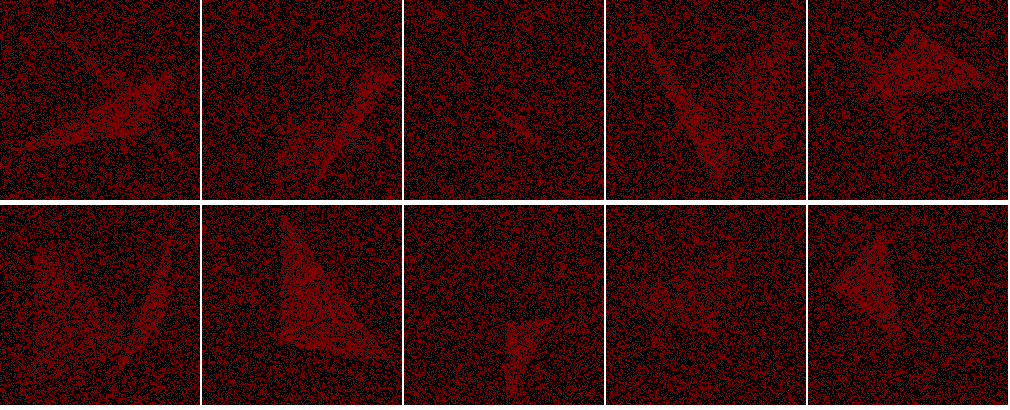

In [16]:
pil_grid([pil(f.byte().cpu().numpy()) for f in preds], 5, margin=1)

## Lovász hinge training

In [17]:
m.bias.data.fill_(0) # reset b

optimizer = Adam(m.parameters(), lr=0.05)

loss_plot = []
iou_plot = []

for iter in tqdm(range(500)):
    optimizer.zero_grad()
    out = m(feats)
    loss = L.lovasz_hinge(out, labels, ignore=255)
    loss.backward()
    optimizer.step()
    
    preds = (out.data > 0).long()
    loss_plot.append(loss.item())
    iou_plot.append(L.iou_binary(preds, labels, ignore=255, per_image=True))

In [18]:
L.lovasz_hinge(out, labels, ignore=255, per_image=True)

tensor(3.2960, device='cuda:0', grad_fn=<DivBackward0>)

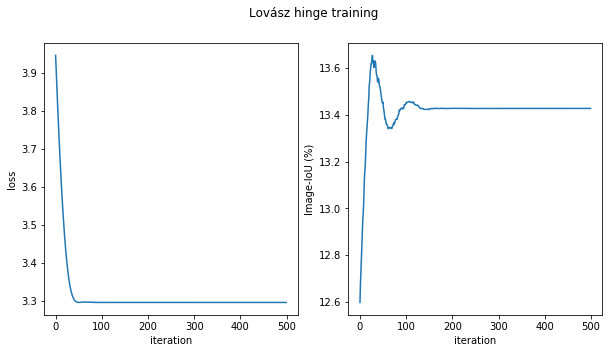

In [19]:
plt.figure(figsize=(10, 5))
plt.suptitle(u'Lovász hinge training')
plt.subplot(1, 2, 1)
plt.plot(loss_plot)
plt.ylabel('loss')
plt.xlabel('iteration')

plt.subplot(1, 2, 2)
plt.plot(iou_plot)
plt.ylabel('Image-IoU (%)')
plt.xlabel('iteration');

### Final prediction

In [20]:
preds = (m(feats) > 0).long().data
print("Final image-IoU:", L.iou_binary(preds, labels, ignore=255, per_image=True))

Final image-IoU: 13.427206918244657


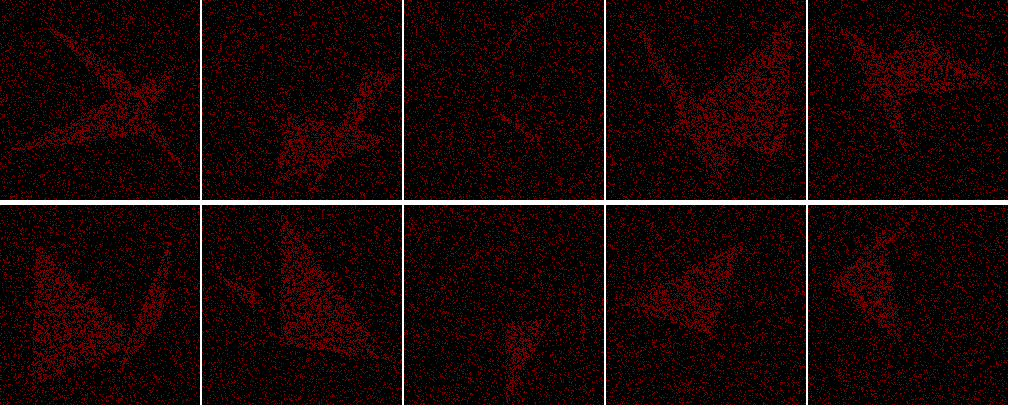

In [21]:
pil_grid([pil(f.byte().cpu().numpy()) for f in preds], 5, margin=1)

## Lovász-Sigmoid training

In [36]:
m.bias.data.fill_(0) # reset b

optimizer = Adam(m.parameters(), lr=0.05)

loss_plot_x = []
iou_plot_x = []

for iter in tqdm(range(500)):
    optimizer.zero_grad()
    logits = m(feats)
    out = torch.sigmoid(logits)
    loss = L.lovasz_softmax(out, labels, classes=[1], ignore=255)
    loss.backward()
    optimizer.step()
    
    preds = (logits.data > 0).long()
    loss_plot_x.append(loss.item())
    iou_plot_x.append(L.iou_binary(preds, labels, ignore=255, per_image=True))

Text(0.5, 0, 'iteration')

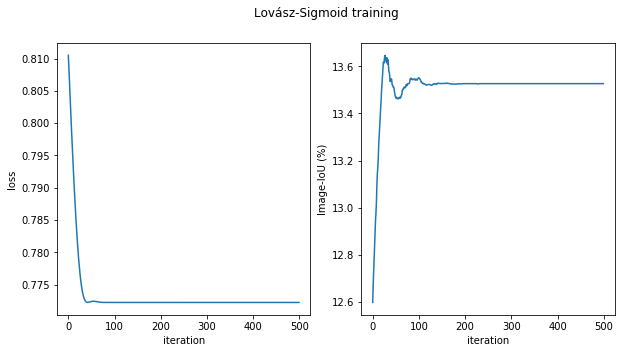

In [37]:
plt.figure(figsize=(10, 5))
plt.suptitle(u'Lovász-Sigmoid training')
plt.subplot(1, 2, 1)
plt.plot(loss_plot_x)
plt.ylabel('loss')
plt.xlabel('iteration')

plt.subplot(1, 2, 2)
plt.plot(iou_plot_x)
plt.ylabel('Image-IoU (%)')
plt.xlabel('iteration')

### Final prediction

In [38]:
preds = (m(feats) > 0).long().data
print("Final image-IoU:", L.iou_binary(preds, labels, ignore=255, per_image=True))

Final image-IoU: 13.526498855652733


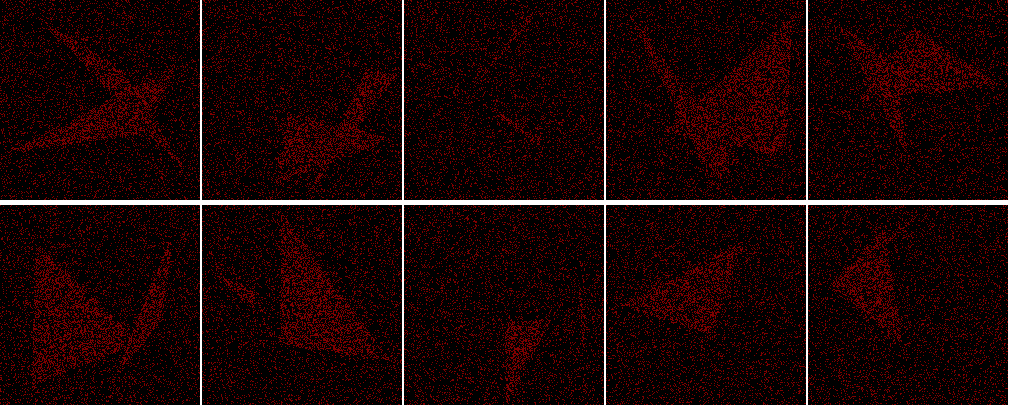

In [39]:
pil_grid([pil(f.byte().cpu().numpy()) for f in preds], 5, margin=1)

## Binary cross-entropy training

In [40]:
m.bias.data.fill_(0) # reset b

optimizer = Adam(m.parameters(), lr=0.05)

loss_plot_x = []
iou_plot_x = []

for iter in tqdm(range(500)):
    optimizer.zero_grad()
    out = m(feats)
    loss = L.binary_xloss(out, labels, ignore=255)
    loss.backward()
    optimizer.step()
    
    preds = (out.data > 0).long()
    loss_plot_x.append(loss.item())
    iou_plot_x.append(L.iou_binary(preds, labels, ignore=255, per_image=True))

Text(0.5, 0, 'iteration')

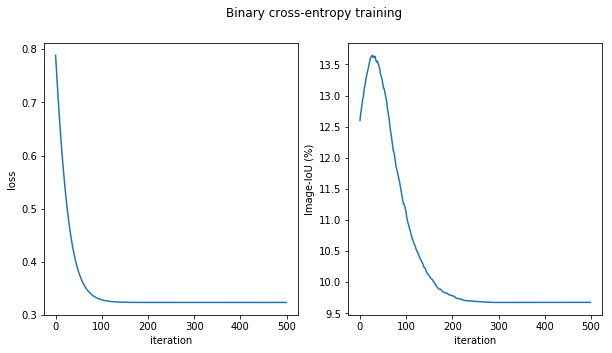

In [41]:
plt.figure(figsize=(10, 5))
plt.suptitle(u'Binary cross-entropy training')
plt.subplot(1, 2, 1)
plt.plot(loss_plot_x)
plt.ylabel('loss')
plt.xlabel('iteration')

plt.subplot(1, 2, 2)
plt.plot(iou_plot_x)
plt.ylabel('Image-IoU (%)')
plt.xlabel('iteration')

### Final prediction

In [28]:
preds = (m(feats) > 0).long().data
print("Final image-IoU:", L.iou_binary(preds, labels, ignore=255, per_image=True))

Final image-IoU: 9.861302507648743


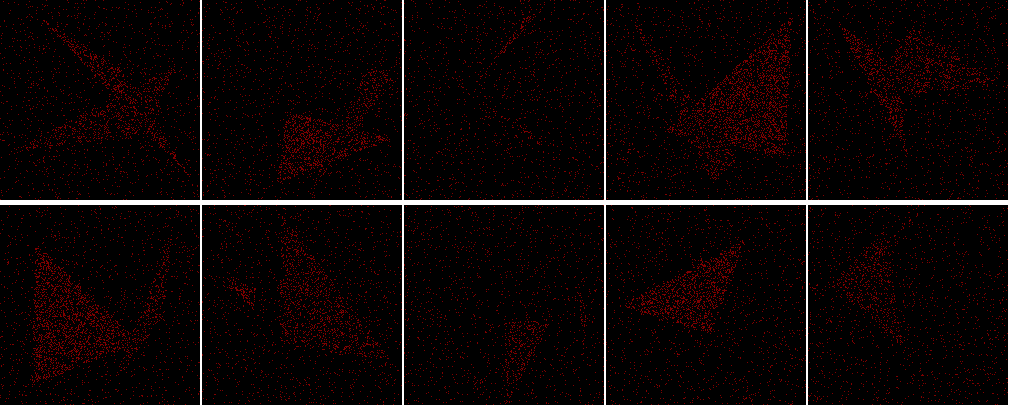

In [29]:
pil_grid([pil(f.byte().cpu().numpy()) for f in preds], 5, margin=1)